# A zoom animation of the mandelbrot function
The fractal is defined by the folowing equation: $z_0 = 0$ and $z_{n+1} = z_n^2 + c$

In [1]:
import matplotlib.pyplot as plt
import sympy
import torch

from cutcutcodec.core.generation.video.fractal.mandelbrot import GeneratorVideoMandelbrot
from cutcutcodec.core.filter.video.equation import FilterVideoEquation
from cutcutcodec.core.filter.video.subclip import FilterVideoSubclip
from cutcutcodec.core.io import write

## Define the complex positions

In [2]:
duration = 10  # video duration
ratio = f"(t/{duration})"
ratio_exp = f"(exp(-1.2*{ratio})-1)/(exp(-1.2)-1)"
bounds = {  # more symbols available in cutcutcodec.core.generation.video.fractal.geometry
    "i_center": f"0.34580*{ratio} + 0*(1-{ratio})",  # from y=0 to y=0.34580
    "j_center": f"0.40253*{ratio} + -1/4*(1-{ratio})",  # from x=-1/4 to x=0.40253
    "i_size": f"0.001*{ratio_exp} + 2*(1-{ratio_exp})",  # y zoom factor
    "j_size": f"3/2 * (0.001*{ratio_exp} + 2*(1-{ratio_exp}))",  # x zoom factor
}
iterations = f"1000*{ratio} + 100*(1-{ratio})"  # from 100 to 1000

In [3]:
(gray_stream,) = GeneratorVideoMandelbrot(bounds, iterations).out_streams

## Look Up Table (LUT)
The output of a ``GeneratorVideoMandelbrot`` is a grayscale video stream, you can define a function to create 3 colors from a single gray.

In [4]:
# create lut
blue = "min(1, max(0, 2-abs(7*(g0-(5/7)))))"
green = "min(1, max(0, 2-abs(7*(g0-(3/7)))))"
red = "min(1, max(0, max(0,3/2-abs(7*(g0-(3/14))))+max(0,1-abs(7*(g0-(6/7))))))"
(bgr_stream,) = FilterVideoEquation([gray_stream], blue, green, red).out_streams

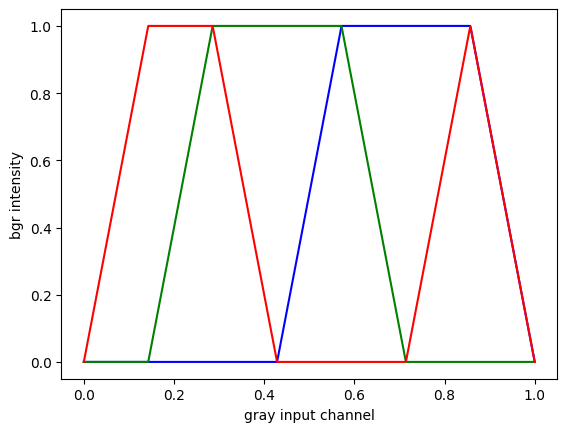

In [5]:
# display gray to bgr function
func = sympy.lambdify(["g0"], bgr_stream.node.colors, modules="math")
gray = torch.linspace(0, 1, 1000).tolist()
lut = [func(g) for g in gray]
plt.xlabel("gray input channel")
plt.ylabel("bgr intensity")
plt.plot(gray, [b for b, _, _ in lut], color="blue")
plt.plot(gray, [g for _, g, _ in lut], color="green")
plt.plot(gray, [r for _, _, r in lut], color="red")
plt.show()

## Write the result

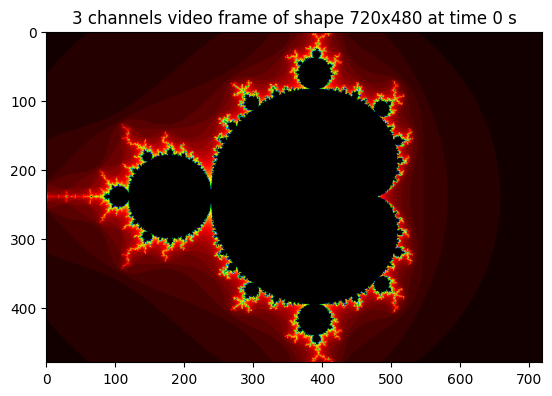

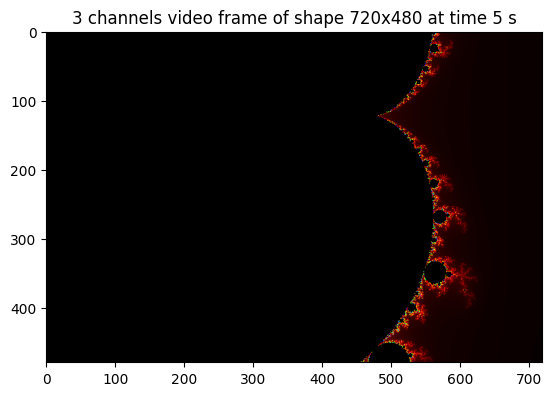

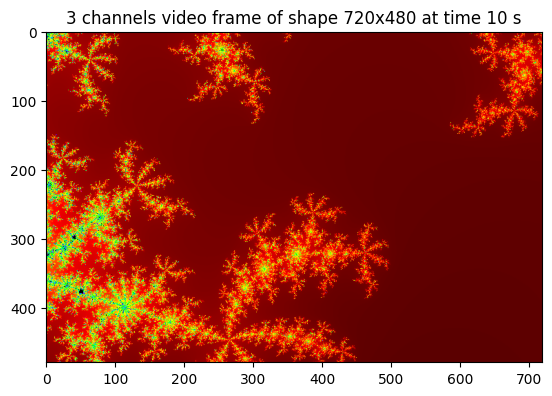

In [6]:
# some snapshot
for time in torch.linspace(0, duration, 3).tolist():
    frame = bgr_stream.snapshot(time, (480, 720))
    plt.imshow(frame.to_numpy_bgr()[..., ::-1])  # bgr to rgb
    plt.title(f"{frame.channels} channels video frame of shape {frame.width}x{frame.height} at time {frame.time} s")
    plt.show()

In [7]:
# write outputfile with low compression (high quality)
(stream,) = FilterVideoSubclip([bgr_stream], 0, duration).out_streams
streams_settings = [
    {"encodec": "libx264", "rate": 30, "shape": (480, 720), "options": {"crf": "23", "preset": "ultrafast"}},
]
write([stream], "/tmp/mandelbrot.mp4", streams_settings)

Encoding mandelbrot.mp4: 100%|███████████████████████████████████████████████████████████| 10.00s/10.00s [01:00<00:00]
